In [ ]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from datasets import load_dataset

import random
import json
from PIL import Image
import pandas as pd
from tqdm import tqdm
import time

import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision

import quantus

from xai_methods import RELAX, LaFAM, GradCAMHeatmap
from utils import *

def choose_device() -> str:
    if torch.cuda.is_available():
        return "cuda:0"
    if hasattr(torch.backends, "mps"):
        if torch.backends.mps.is_available():
            return "mps"
    return "cpu"

device = torch.device(choose_device())
print(torch.cuda.get_device_name(device))

# fix seed for reproducibility
seed = 123
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed) # multi-GPU

In [2]:
# Load labels from json file
with open("imagenet_class_index.json") as f:
    imagenet_labels = list(json.load(f).values())

imagenet_transform = torchvision.transforms.Compose(
    [
        SquareCropAndResize(224),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),
    ]
)

inverse_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Normalize(
            mean=[0.0, 0.0, 0.0], std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
        ),
        torchvision.transforms.Normalize(
            mean=[-0.485, -0.456, -0.406], std=[1.0, 1.0, 1.0]
        ),
    ]
)

quantus_metrics = [
    quantus.PointingGame,
    quantus.TopKIntersection,
    quantus.Sparseness,
    quantus.AUC,
    quantus.AttributionLocalisation,
    quantus.RelevanceRankAccuracy,
    quantus.RelevanceMassAccuracy,
]

### Load models

In [3]:
resnet = torchvision.models.resnet50(weights="ResNet50_Weights.IMAGENET1K_V1")
# resnet = torchvision.models.resnet50(pretrained=True)
resnet.eval().to(device)

layer_idx = get_layer_idx(resnet, resnet.layer4)
# print("Layer index: ", layer_idx)

# Take only CCN layers
resnet_layer4 = torch.nn.Sequential(*list(resnet.children())[: layer_idx + 1])
resnet_layer4.eval();
# list(resnet_layer4.children())[-1]

In [ ]:
from pl_bolts.models.self_supervised import SimCLR, SwAV


simclr = (
    SimCLR.load_from_checkpoint(
        "https://pl-bolts-weights.s3.us-east-2.amazonaws.com/simclr/bolts_simclr_imagenet/simclr_imagenet.ckpt",
        strict=False,
    )
    .encoder.eval()
    .to(device)
)
layer_idx = get_layer_idx(simclr, simclr.layer4)
simclr_layer4 = torch.nn.Sequential(*list(simclr.children())[: layer_idx + 1])
simclr_layer4.eval().to(device)

swav = (
    SwAV.load_from_checkpoint(
        "https://pl-bolts-weights.s3.us-east-2.amazonaws.com/swav/bolts_swav_imagenet/swav_imagenet.ckpt",
        strict=False,
    )
    .model
    .eval()
    .to(device)
)
layer_idx = get_layer_idx(swav, swav.layer4)
swav_layer4 = torch.nn.Sequential(*list(swav.children())[: layer_idx + 1])
swav_layer4.eval().to(device);

In [21]:
xai_methods = (
    ("ResNet LaFAM", LaFAM(resnet_layer4, interpolation="nearest", threshold=None)),
    ("SimCLR LaFAM", LaFAM(simclr_layer4, interpolation="nearest", threshold=None)),
    (
        "SimCLR RELAX",
        RELAX(
            simclr,
            n_masks=2048,
            n_cells=7,
            occlusion_batch_size=1024,
            threshold=None,
            unpack_output=lambda x: x[0],
            device=device,
            mask_interpolation="nearest",
            heatmap_interpolation="nearest",
        ),
    ),
    ("SwAV LaFAM", LaFAM(swav_layer4, interpolation="nearest", threshold=None)),
    (
        "SwAV RELAX",
        RELAX(
            swav,
            n_masks=2048,
            n_cells=7,
            occlusion_batch_size=1024,
            threshold=None,
            unpack_output=lambda x: x[0],
            device=device,
            mask_interpolation="nearest",
            heatmap_interpolation="nearest",
        ),
    ),
)

gradcam_heatmap = GradCAMHeatmap(
    resnet, resnet.layer4, imagenet_labels, interpolation="nearest", threshold=None
)

# for visualization
# without interpolation for vector plot (resulting in a heatmap with 7x7)
xai_methods_no_interpolation = (
    ("ResNet LaFAM", LaFAM(resnet_layer4, interpolation=None, threshold=None)),
    ("SimCLR LaFAM", LaFAM(simclr_layer4, interpolation=None, threshold=None)),
    (
        "SimCLR RELAX",
        RELAX(
            simclr,
            n_masks=2048,
            n_cells=7,
            occlusion_batch_size=1024,
            threshold=None,
            unpack_output=lambda x: x[0],
            device=device,
            mask_interpolation="nearest",
            heatmap_interpolation=None,
        ),
    ),
    ("SwAV LaFAM", LaFAM(swav_layer4, interpolation=None, threshold=None)),
    (
        "SwAV RELAX",
        RELAX(
            swav,
            n_masks=2048,
            n_cells=7,
            occlusion_batch_size=1024,
            threshold=None,
            unpack_output=lambda x: x[0],
            device=device,
            mask_interpolation="nearest",
            heatmap_interpolation=None,
        ),
    ),
)

gradcam_heatmap_no_interpolation = GradCAMHeatmap(
    resnet, resnet.layer4, imagenet_labels, interpolation=None, threshold=None
)

# ImageNet-1k + ImageNet-S

You may need to accept the huggingface terms and conditions to download the [imagenet-1k](https://huggingface.co/datasets/imagenet-1k) dataset. Also, make sure you have run `huggingface-cli login`.

In [6]:
imgent_ds = load_dataset("imagenet-1k", streaming=False, split="validation")


### Convert huggingface dataset to dataframe

In [7]:
rows = []
for i, (img, l) in enumerate(zip(imgent_ds._data["image"], imgent_ds._data["label"])):
    l = l.as_py()
    path = img["path"].as_py()
    row = {}
    row["category"] = path.split("/")[-1].split("_")[-1].split(".")[0]
    row["filename"] = path.split("/")[-1].split("_n")[0]
    row["label_names"] = imagenet_labels[l]
    row["label"] = l
    row["dataset_idx"] = i
    rows.append(row)

# set dtype int instead of numpy.int64
imgent_df = pd.DataFrame(rows)
del rows
imgent_df.head()

,category,filename,label_names,label,dataset_idx
0,n01824575,ILSVRC2012_val_00027555,coucal,91,0
1,n02091032,ILSVRC2012_val_00006054,Italian greyhound,171,1
2,n09472597,ILSVRC2012_val_00027621,volcano,980,2
3,n02102177,ILSVRC2012_val_00006947,Welsh springer spaniel,218,3
4,n01592084,ILSVRC2012_val_00048107,chickadee,19,4


### Map ImageNet-1k to ImageNet-S

Before mapping the ImageNet-1k to [ImageNet-S](https://github.com/LUSSeg/ImageNet-S), you need to download [ImageNetS919](https://github.com/LUSSeg/ImageNet-S/releases/download/ImageNet-S/ImageNetS919-5f7f58ae1003d21da9409a8576bf7680.zip). Make sure you have the right path to the ImageNetS919 folder.

In [8]:
import glob

file_paths = glob.glob("../../ImageNetS919/validation-segmentation/*/*")
imgnet_s_path = [path.split("/")[-1].split(".")[0] for path in file_paths]
print(len(file_paths), len(imgnet_s_path))
imgnet_s_path[:5]

12419 12419


['ILSVRC2012_val_00045125',
 'ILSVRC2012_val_00002791',
 'ILSVRC2012_val_00001629',
 'ILSVRC2012_val_00012003',
 'ILSVRC2012_val_00036287']

In [9]:
# match names and dataframe
imgnet_s_df = imgent_df[imgent_df["filename"].isin(imgnet_s_path)].copy()
# match file_paths and df_seg['filename']
imgnet_s_df["file_path"] = imgnet_s_df["filename"].apply(
    lambda x: file_paths[imgnet_s_path.index(x)]
)

print(len(imgnet_s_df))
imgnet_s_df[['filename', 'file_path']].head()

12419


,filename,file_path
0,ILSVRC2012_val_00027555,../../ImageNetS919/validation-segmentation/n01...
3,ILSVRC2012_val_00006947,../../ImageNetS919/validation-segmentation/n02...
6,ILSVRC2012_val_00034999,../../ImageNetS919/validation-segmentation/n03...
7,ILSVRC2012_val_00010453,../../ImageNetS919/validation-segmentation/n04...
14,ILSVRC2012_val_00002723,../../ImageNetS919/validation-segmentation/n02...


Extract labels from segmentation masks (see [here](https://github.com/LUSSeg/ImageNet-S?tab=readme-ov-file#qa) for more details).

In [10]:
def get_seg_id(path):
    segmentation = Image.open(path)  # RGB
    segmentation = np.array(segmentation)
    seg = segmentation[:, :, 1] * 256 + segmentation[:, :, 0]  # R+G*256
    seg = np.unique(seg)
    seg = seg[(seg != 0) & (seg != 1000)]
    return seg


imgnet_s_df["segmentation_id"] = imgnet_s_df["file_path"].apply(lambda x: get_seg_id(x))
imgnet_s_df.head()

,category,filename,label_names,label,dataset_idx,file_path,segmentation_id
0,n01824575,ILSVRC2012_val_00027555,coucal,91,0,../../ImageNetS919/validation-segmentation/n01...,[92]
3,n02102177,ILSVRC2012_val_00006947,Welsh springer spaniel,218,3,../../ImageNetS919/validation-segmentation/n02...,[219]
6,n03291819,ILSVRC2012_val_00034999,envelope,549,6,../../ImageNetS919/validation-segmentation/n03...,[521]
7,n04259630,ILSVRC2012_val_00010453,sombrero,808,7,../../ImageNetS919/validation-segmentation/n04...,[757]
14,n02328150,ILSVRC2012_val_00002723,"Angora, Angora rabbit",332,14,../../ImageNetS919/validation-segmentation/n02...,[333]


In [11]:
imgnet_s_df = imgnet_s_df[imgnet_s_df["segmentation_id"].apply(lambda x: len(x)) == 1].copy()
print(len(imgnet_s_df))
imgnet_s_df.head()

11294


,category,filename,label_names,label,dataset_idx,file_path,segmentation_id
0,n01824575,ILSVRC2012_val_00027555,coucal,91,0,../../ImageNetS919/validation-segmentation/n01...,[92]
3,n02102177,ILSVRC2012_val_00006947,Welsh springer spaniel,218,3,../../ImageNetS919/validation-segmentation/n02...,[219]
6,n03291819,ILSVRC2012_val_00034999,envelope,549,6,../../ImageNetS919/validation-segmentation/n03...,[521]
7,n04259630,ILSVRC2012_val_00010453,sombrero,808,7,../../ImageNetS919/validation-segmentation/n04...,[757]
14,n02328150,ILSVRC2012_val_00002723,"Angora, Angora rabbit",332,14,../../ImageNetS919/validation-segmentation/n02...,[333]


### Saliency map visualization

100%|██████████| 3/3 [00:04<00:00,  1.47s/it]


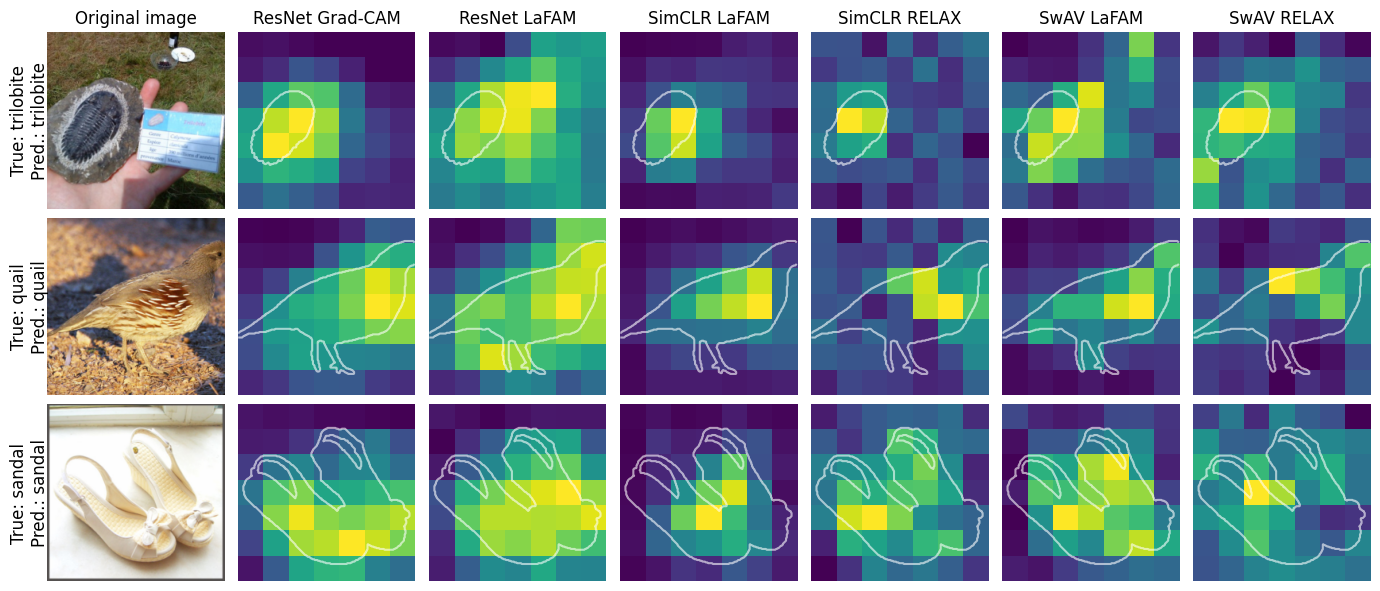

In [22]:
df_sample = imgnet_s_df.sample(3)

fig, axes = plt.subplots(
    nrows=len(df_sample),
    ncols=len(xai_methods) + 2,
    figsize=((len(xai_methods) + 2) * 2, 2 * len(df_sample)),
)
for ax in axes.flatten():
    ax.axis("off")

x = np.linspace(0, 224, 8)
y = np.linspace(0, 224, 8)
X, Y = np.meshgrid(x, y)

for i, row in enumerate(tqdm(df_sample.itertuples(), total=len(df_sample))):
    img = imgent_ds[int(row.dataset_idx)]['image'].convert("RGB")
    img = SquareCropAndResize(224)(img)
    img_tensor = imagenet_transform(img).unsqueeze(0).to(device)


    seg_img = Image.open(row.file_path)
    seg_img = SquareCropAndResize(224)(seg_img)
    seg_img = np.array(seg_img)

    mask = np.array(seg_img[:, :, 0]).astype(np.float32)

    mask[mask != 0] = 1
    mask_alpha = plt.cm.gray(mask)
    mask_alpha[..., 3] = mask

    if i == 0:
        axes[i, 0].title.set_text("Original image")
        axes[i, 1].title.set_text("ResNet Grad-CAM")

    axes[i, 0].imshow(img)

    # Grad-CAM
    heatmap, pred_label = gradcam_heatmap_no_interpolation(img_tensor)
    heatmap = np.flipud(heatmap[0].cpu().numpy())
                                     

    # plot heatmap as vector graphic
    axes[i, 1].pcolormesh(X, Y, heatmap, cmap='viridis', shading='auto')
    axes[i, 1].set_aspect('equal')
    axes[i, 1].contour(mask[::-1], levels=[0.5], colors='w', alpha=0.6)

    # add vertical title left
    true_label = imagenet_labels[row.label]
    true_label = true_label.split(",")[0]
    axes[i, 0].text(
        -0.1,
        0.5,
        f"True: {true_label}\nPred.: {pred_label}",
        size=12,
        ha="center",
        va="center",
        rotation=90,
        transform=axes[i, 0].transAxes,
    )

    for j, method_info in enumerate(xai_methods_no_interpolation):
        name, method = method_info
        heatmap = method(img_tensor, silent=True)
        if i == 0:
            axes[i, j + 2].title.set_text(name)
        heatmap = np.flipud(heatmap[0].cpu().numpy())
        axes[i, j + 2].pcolormesh(X, Y, heatmap, cmap='viridis', shading='auto')
        axes[i, j + 2].set_aspect('equal')
        axes[i, j + 2].contour(mask[::-1], levels=[0.5], colors='w', alpha=0.6)

plt.tight_layout()
# remove margins
plt.subplots_adjust(wspace=0, hspace=0.05)

### Evaluation

In [12]:
target_transform = SquareCropAndResize(224, interpolation=Image.NEAREST)

results = []

for _, row in tqdm(imgnet_s_df.iterrows(), total=len(imgnet_s_df)):
    ds_idx = int(row["dataset_idx"])

    img = imgent_ds[ds_idx]["image"]
    img = imagenet_transform(img.convert("RGB"))
    x_batch = img.to(device).unsqueeze(0)

    seg = Image.open(row["file_path"])
    seg = target_transform(seg)
    seg = np.array(seg)
    seg = seg[:, :, 1] * 256 + seg[:, :, 0]

    m = seg.max()
    mask = torch.zeros(seg.shape)
    mask[seg == m] = 1
    s_batch = mask.unsqueeze(0)

    start = time.time()
    a_batch, pred_label = gradcam_heatmap(x_batch)
    total_time = time.time() - start

    result = {
        "dataset_idx": ds_idx,
        "total_time": total_time,
        "prediction": pred_label,
        "labels": row["label_names"],
        "xai_method": "ResNet Grad-CAM",
    }

    result.update(evaluate(x_batch, s_batch, a_batch.detach(), quantus_metrics, device))
    results.append(result)

    for method_info in xai_methods:
        name, xai_method = method_info

        start = time.time()
        a_batch = xai_method(x_batch, silent=True)
        total_time = time.time() - start

        result = {
            "dataset_idx": ds_idx,
            "total_time": total_time,
            "prediction": pred_label,
            "labels": row["label_names"],
            "xai_method": name,
        }

        r = evaluate(x_batch, s_batch, a_batch, quantus_metrics, device)
        result.update(r)
        results.append(result)

100%|██████████| 11294/11294 [5:31:34<00:00,  1.76s/it] 


In [13]:
results_df = pd.DataFrame(results)
results_df.tail()

,dataset_idx,total_time,prediction,labels,xai_method,Pointing-Game,Top-K Intersection,Sparseness,AUC,Attribution Localisation,Relevance Rank Accuracy,Relevance Mass Accuracy
67759,49994,0.006209,palace,palace,ResNet LaFAM,True,0.968,0.263876,0.908207,0.750743,0.853621,0.750743
67760,49994,0.006430,palace,palace,SimCLR LaFAM,True,1.000,0.568161,0.820356,0.845197,0.726174,0.845197
67761,49994,0.018463,palace,palace,SimCLR RELAX,True,1.000,0.295197,0.789360,0.696527,0.804283,0.696527
67762,49994,0.006241,palace,palace,SwAV LaFAM,True,1.000,0.373437,0.936875,0.824573,0.919575,0.824573
67763,49994,0.019705,palace,palace,SwAV RELAX,True,1.000,0.330274,0.769555,0.713207,0.733903,0.713207


In [14]:
results_df.to_csv("imagenet.csv", index=False, header=True)

In [15]:
cols = [metric.name for metric in quantus_metrics]
cols.append("total_time")
cols.append("xai_method")
results_df[cols].groupby("xai_method").mean().T

xai_method,ResNet Grad-CAM,ResNet LaFAM,SimCLR LaFAM,SimCLR RELAX,SwAV LaFAM,SwAV RELAX
Pointing-Game,0.940057,0.906765,0.921463,0.882947,0.899061,0.854702
Top-K Intersection,0.750728,0.690983,0.765947,0.712115,0.716823,0.638394
Sparseness,0.427421,0.348207,0.497084,0.352685,0.399218,0.314957
AUC,0.831283,0.804592,0.812878,0.764974,0.830319,0.701319
Attribution Localisation,0.502880,0.458937,0.533250,0.461926,0.501368,0.429650
Relevance Rank Accuracy,0.622265,0.595096,0.614487,0.581397,0.646978,0.536474
Relevance Mass Accuracy,0.502880,0.458937,0.533250,0.461926,0.501368,0.429650
total_time,0.015692,0.005948,0.006123,0.017891,0.006606,0.019321


# PASCAL Segmentation


In [23]:
pascal_labels = {
    1: "aeroplane",
    2: "bicycle",
    3: "bird",
    4: "boat",
    5: "bottle",
    6: "bus",
    7: "car",
    8: "cat",
    9: "chair",
    10: "cow",
    11: "diningtable",
    12: "dog",
    13: "horse",
    14: "motorbike",
    15: "person",
    16: "potted plant",
    17: "sheep",
    18: "sofa",
    19: "train",
    20: "tv/monitor",
}


pascal_ds = torchvision.datasets.VOCSegmentation(
    root="../data/VOCdevkit",
    year="2012",
    image_set="val",
    download=False,
    transform=imagenet_transform,
    target_transform=SquareCropAndResize(224, interpolation=Image.NEAREST),
)



### Create pandas dataframe from torch dataset


Number of images: 1449


<Axes: title={'center': 'Pascal VOC 2012 - labels distribution'}, xlabel='label_names'>

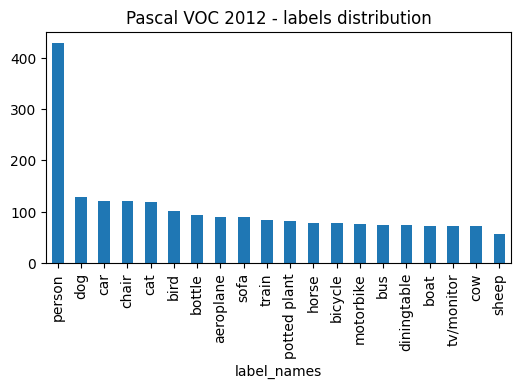

In [24]:
data = []

for idx, (_, mask) in enumerate(pascal_ds):
    mask = np.array(mask)
    labels = np.unique(mask)
    labels = labels[(labels != 0) & (labels != 255)]

    data.append(
        {
            "dataset_idx": idx,
            "labels": labels,
            "label_count": len(labels),
            "label_names": [pascal_labels[label] for label in labels],
        }
    )

# Create a pandas dataframe
pascal_df = pd.DataFrame(data)


print(f"Number of images: {len(pascal_df)}")

pascal_df["label_names"].explode().value_counts().plot(
    kind="bar", figsize=(6, 3), title="Pascal VOC 2012 - labels distribution"
)

Number of images: 753


<Axes: title={'center': 'Pascal VOC 2012 - labels distribution'}, xlabel='label_names'>

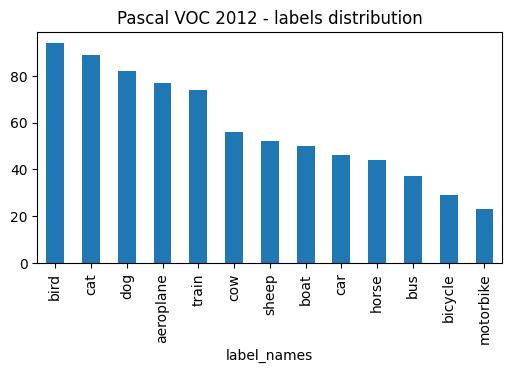

In [25]:
pascal_df = pascal_df[pascal_df["label_count"] == 1].copy()

exclude_classes = [
    "person",
    "tv/monitor",
    "sofa",
    "potted plant",
    "diningtable",
    "chair",
    "bottle",
]
pascal_df = pascal_df[
    ~pascal_df["label_names"].apply(lambda x: any(cls in x for cls in exclude_classes))
].copy()

print(f"Number of images: {len(pascal_df)}")

pascal_df["label_names"].explode().value_counts().plot(
    kind="bar", figsize=(6, 3), title="Pascal VOC 2012 - labels distribution"
)

### Visualization

100%|██████████| 3/3 [00:04<00:00,  1.48s/it]


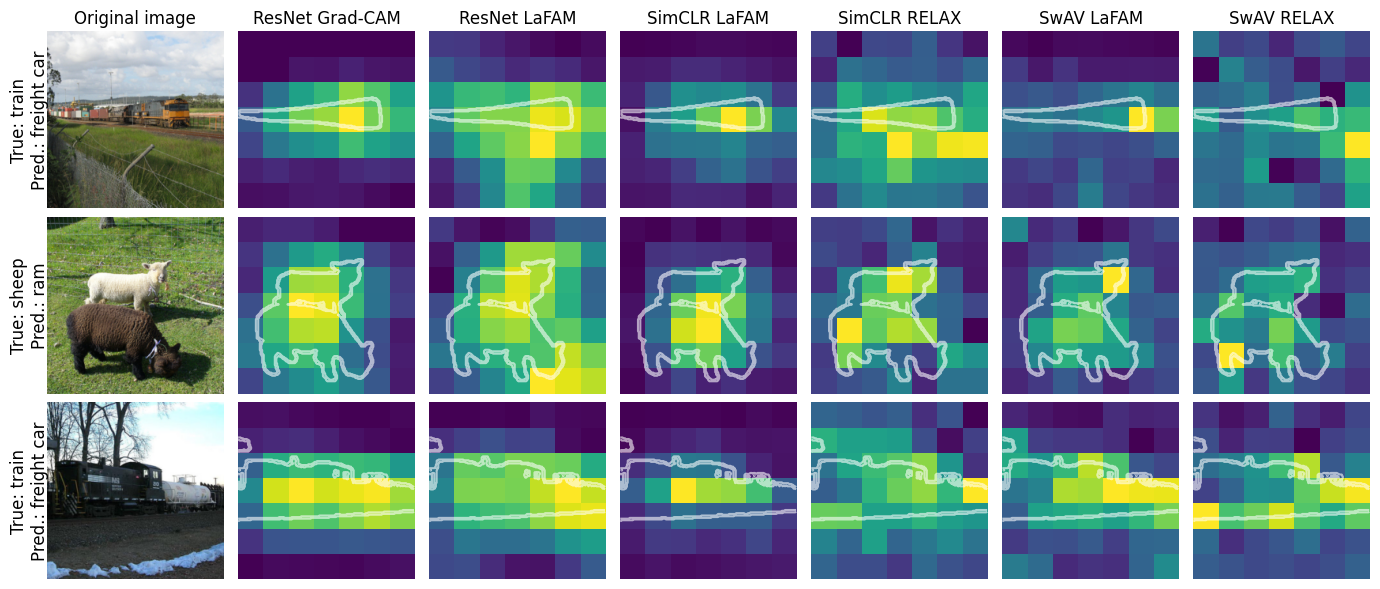

In [28]:
df_sample = pascal_df.sample(3)

fig, axes = plt.subplots(
    nrows=len(df_sample),
    ncols=len(xai_methods) + 2,
    figsize=((len(xai_methods) + 2) * 2, 2 * len(df_sample)),
)
for ax in axes.flatten():
    ax.axis("off")

x = np.linspace(0, 224, 8)
y = np.linspace(0, 224, 8)
X, Y = np.meshgrid(x, y)

for i, row in enumerate(tqdm(df_sample.itertuples(), total=len(df_sample))):
    img_tensor, seg_img = pascal_ds[row.dataset_idx]
    img = inverse_transform(img_tensor).permute(1, 2, 0).numpy()

    img_tensor = img_tensor.unsqueeze(0).to(device)

    seg = np.array(seg_img)
    # remove outline
    seg[seg == 255] = 0

    seg_classes = np.unique(seg)
    seg_classes = seg_classes[seg_classes != 0]
    seg_labels = [pascal_labels[i] for i in seg_classes]
    seg_labels = ", ".join(seg_labels)

    seg = np.array(seg_img)
    mask = np.zeros_like(seg).astype(np.float32)
    mask[seg == 255] = 1
    mask_alpha = plt.cm.gray(mask)
    mask_alpha[..., 3] = mask

    if i == 0:
        axes[i, 0].title.set_text("Original image")
        axes[i, 1].title.set_text("ResNet Grad-CAM")

    axes[i, 0].imshow(img, vmin=img.min(), vmax=img.max())

    # Grad-CAM
    heatmap, pred_label = gradcam_heatmap_no_interpolation(img_tensor)
    heatmap = np.flipud(heatmap[0].cpu().numpy())
                                     

    # plot heatmap as vector graphic
    axes[i, 1].pcolormesh(X, Y, heatmap, cmap='viridis', shading='auto')
    axes[i, 1].set_aspect('equal')
    axes[i, 1].contour(mask[::-1], levels=[0.5], colors='w', alpha=0.6)

    # add vertical title left
    axes[i, 0].text(
        -0.1,
        0.5,
        f"True: {seg_labels}\nPred.: {pred_label}",
        size=12,
        ha="center",
        va="center",
        rotation=90,
        transform=axes[i, 0].transAxes,
    )

    for j, method_info in enumerate(xai_methods_no_interpolation):
        name, method = method_info
        heatmap = method(img_tensor, silent=True)
        if i == 0:
            axes[i, j + 2].title.set_text(name)
        heatmap = np.flipud(heatmap[0].cpu().numpy())
        axes[i, j + 2].pcolormesh(X, Y, heatmap, cmap='viridis', shading='auto')
        axes[i, j + 2].set_aspect('equal')
        axes[i, j + 2].contour(mask[::-1], levels=[0.5], colors='w', alpha=0.6)

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0.05)

### Evaluation


In [19]:
# torch dataset wrapper for pandas dataframe
class PascalVOC2012Seg(torch.utils.data.Dataset):
    def __init__(self, df, ds):
        self.df = df
        self.ds = ds

    def __getitem__(self, idx):
        # get df row
        row = self.df.iloc[idx]

        img, seg = self.ds[row.dataset_idx]

        seg = torch.tensor(np.array(seg))

        # remove outline
        seg[seg == 255] = 0
        seg[seg > 0] = 1

        return img, seg, row.to_dict()

    def __len__(self):
        return len(self.df)


pasvoc2012_seg = PascalVOC2012Seg(pascal_df, pascal_ds)

In [20]:


results = []

for batch in tqdm(torch.utils.data.DataLoader(pasvoc2012_seg, batch_size=1)):
    x_batch = batch[0].to(device)
    s_batch = batch[1]
    row = batch[2]

    ds_idx = row["dataset_idx"].item()

    start = time.time()
    a_batch, pred_label = gradcam_heatmap(x_batch)
    total_time = time.time() - start

    result = {
        "dataset_idx": ds_idx,
        "total_time": total_time,
        "prediction": pred_label,
        "labels": row["label_names"][0],
        "xai_method": "ResNet Grad-CAM",
    }

    result.update(evaluate(x_batch, s_batch, a_batch.detach(), quantus_metrics, device))
    results.append(result)

    for method_info in xai_methods:
        name, xai_method = method_info

        start = time.time()
        a_batch = xai_method(x_batch, silent=True)
        total_time = time.time() - start

        result = {
            "dataset_idx": ds_idx,
            "total_time": total_time,
            "prediction": pred_label,
            "labels": row["label_names"][0],
            "xai_method": name,
        }

        r = evaluate(x_batch, s_batch, a_batch, quantus_metrics, device)
        result.update(r)
        results.append(result)

100%|██████████| 753/753 [22:05<00:00,  1.76s/it]


In [21]:
results_df = pd.DataFrame(results)
results_df.tail()

,dataset_idx,total_time,prediction,labels,xai_method,Pointing-Game,Top-K Intersection,Sparseness,AUC,Attribution Localisation,Relevance Rank Accuracy,Relevance Mass Accuracy
4513,1444,0.005700,electric locomotive,"(train,)",ResNet LaFAM,True,1.000,0.278604,0.777916,0.868931,0.850754,0.868931
4514,1444,0.005889,electric locomotive,"(train,)",SimCLR LaFAM,True,1.000,0.411123,0.845446,0.922505,0.877945,0.922505
4515,1444,0.017192,electric locomotive,"(train,)",SimCLR RELAX,True,1.000,0.218790,0.556188,0.812157,0.806235,0.812157
4516,1444,0.006366,electric locomotive,"(train,)",SwAV LaFAM,True,0.953,0.247627,0.719234,0.846548,0.871614,0.846548
4517,1444,0.018645,electric locomotive,"(train,)",SwAV RELAX,True,0.953,0.235849,0.405896,0.763185,0.773495,0.763185


In [22]:
results_df.to_csv("pascal.csv", index=False, header=True)

In [23]:
cols = [metric.name for metric in quantus_metrics]
cols.append("total_time")
cols.append("xai_method")
results_df[cols].groupby("xai_method").mean().T

xai_method,ResNet Grad-CAM,ResNet LaFAM,SimCLR LaFAM,SimCLR RELAX,SwAV LaFAM,SwAV RELAX
Pointing-Game,0.908367,0.912351,0.946879,0.916335,0.936255,0.827357
Top-K Intersection,0.654657,0.634268,0.750560,0.678299,0.676329,0.562251
Sparseness,0.443953,0.362055,0.510082,0.360480,0.416122,0.323628
AUC,0.828715,0.840086,0.853320,0.798825,0.877422,0.712489
Attribution Localisation,0.404466,0.371309,0.456765,0.380026,0.421797,0.341808
Relevance Rank Accuracy,0.535358,0.539457,0.587335,0.545573,0.610546,0.464042
Relevance Mass Accuracy,0.404466,0.371309,0.456765,0.380026,0.421797,0.341808
total_time,0.015193,0.005815,0.005978,0.017430,0.006410,0.018798
